<a href="https://colab.research.google.com/github/farnazmnz/Time-Series-Forecasting/blob/main/6_demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_excel('data_demand.xlsx')

In [ ]:
data

,Unnamed: 0,Date_x,GDS_x,PLN_GROUP_x,QUALITY_F_x,DES_EN_x,YYMM_x,Date & GDS & PLN,Demand
0,0,0,3602006,VP,OEM/GS,TR,140001,OEM/GS-3602006-140001-VP,914
1,1,0,3602006,VP,OEM/GS,TR,140209,OEM/GS-3602006-140209-VP,1818
2,2,0,3602006,VP,OEM/GS,TR,140208,OEM/GS-3602006-140208-VP,2057
3,3,0,3602006,VP,OEM/GS,TR,140207,OEM/GS-3602006-140207-VP,2153
4,4,0,3602006,VP,OEM/GS,TR,140206,OEM/GS-3602006-140206-VP,1539
...,...,...,...,...,...,...,...,...,...
3362,3362,108,5402114,SP,OEM/GS,PC,140007,OEM/GS-5402114-140007-SP,9
3363,3363,108,5402114,SP,OEM/GS,PC,140005,OEM/GS-5402114-140005-SP,135
3364,3364,108,5402114,SP,OEM/GS,PC,140004,OEM/GS-5402114-140004-SP,123
3365,3365,108,5402114,SP,OEM/GS,PC,140107,OEM/GS-5402114-140107-SP,124


In [ ]:
data['Date_x'].value_counts()

Date_x
0      33
80     33
42     33
46     33
47     33
       ..
34     25
70     25
105    23
17     21
52     20
Name: count, Length: 109, dtype: int64

In [ ]:
dfs = {}

for i in range(0, 103):
    dfs[i] = data[data['Date_x'] == i]

In [ ]:
dfs[0] = dfs[0].sort_values(by='YYMM_x', ascending=True)

In [ ]:
df = dfs[0]

In [ ]:
df = df.drop(columns=['Unnamed: 0' ,'Date_x' ,'GDS_x' ,'PLN_GROUP_x' ,'QUALITY_F_x' ,'DES_EN_x' ,'YYMM_x', 'Date & GDS & PLN'])

In [ ]:
df

,Demand
0,914
25,913
19,986
20,951
21,770
22,998
23,917
24,1269
32,1285
26,984


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

### LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation
from keras.regularizers import l2

In [ ]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i + seq_length]
        sequences.append(sequence)
    return np.array(sequences)

In [ ]:
df_lstm = df.copy()

In [ ]:
prices = df_lstm['Demand'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)
sequence_length = 5
X = create_sequences(prices_scaled, sequence_length)
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model_lstm = Sequential()
model_lstm.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(units=64, return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(LSTM(units=32))
model_lstm.add(Dense(units=1, kernel_regularizer=l2(0.001)))
model_lstm.add(Activation('linear'))

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model_lstm.fit(X_train, X_train[:, -1], epochs=20, batch_size=16, verbose=1)

last_sequence = prices_scaled[-sequence_length:].reshape(1, sequence_length, 1)
predicted_prices = []
for _ in range(12):
    next_pred = model_lstm.predict(last_sequence)[0]
    predicted_prices.append(next_pred)
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_pred]], axis=1)

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

predicted_test_prices = model_lstm.predict(X_test)
predicted_test_prices = scaler.inverse_transform(predicted_test_prices)
actual_test_prices = scaler.inverse_transform(X_test[:, -1]).reshape(-1, 1)
mse = mean_squared_error(actual_test_prices, predicted_test_prices)
print(f"Mean Squared Error (MSE) on Test Set: {mse:.2f}")

C:\Users\IDS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.7832
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1879
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0757
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0504 
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0667
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0561
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0531
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0614
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0402
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0438
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0457
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0382
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0397
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0383
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0378
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━

In [ ]:
df_to_append = pd.DataFrame(columns=df_lstm.columns)
df_to_append['Demand'] = predicted_prices.flatten()
for column in df_to_append.columns:
    if column != 'Demand':
        df_to_append[column] = 0
df_lstm = pd.concat([df_lstm, df_to_append], ignore_index=True)

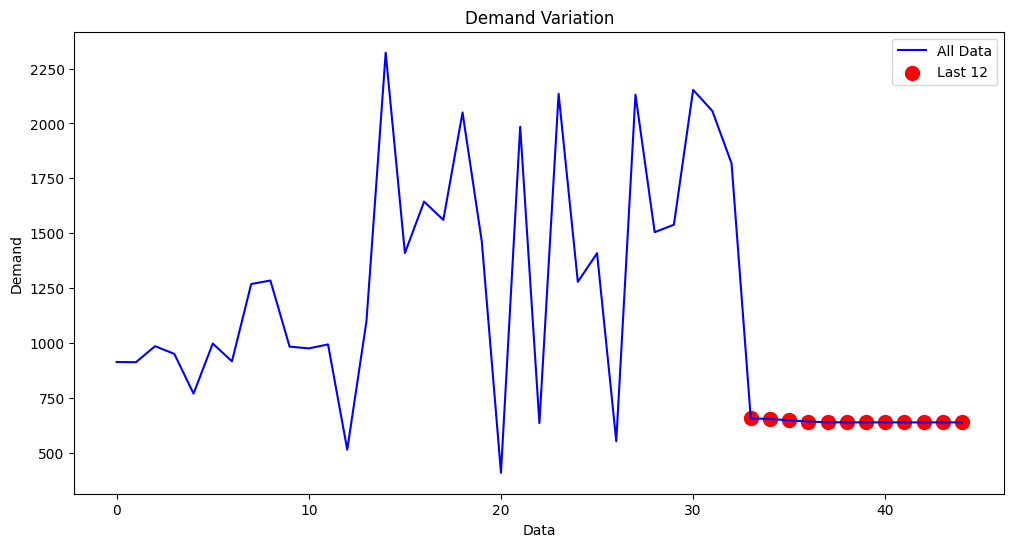

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index, df_lstm['Demand'], label='All Data', color='blue')
plt.scatter(df_lstm.index[-12:], df_lstm['Demand'].tail(12), color='red', label='Last 12', s=100)
plt.xlabel('Data')
plt.ylabel('Demand')
plt.title('Demand Variation')
plt.legend()
plt.show()

In [ ]:
df_lstm

,Demand
0,914.000000
1,913.000000
2,986.000000
3,951.000000
4,770.000000
5,998.000000
6,917.000000
7,1269.000000
8,1285.000000
9,984.000000


In [ ]:
df_lstm['Percentage Change'] = df_lstm['Demand'].pct_change() * 100

tolerance = 20
increasing_trend = ((df_lstm['Percentage Change'] >= -tolerance) & (df_lstm['Percentage Change'] <= tolerance)).all()

if increasing_trend:
    print("The product has an increasing trend with a tolerance of 20%.")
else:
    print("The product has a decreasing trend with a tolerance of 20%.")

The product has a decreasing trend with a tolerance of 20%.


### Arima

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import itertools

In [ ]:
df_arima = df.copy()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
x = df_arima['Demand'].values

x = x.astype(np.float64)

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

x = np.asarray(x)

best_aic = np.inf
best_order = None
best_seasonal_order = None

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(x,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

print(f"Best ARIMA model: ARIMA{best_order}x{best_seasonal_order}12 - AIC:{best_aic}")

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:558.0734574963451
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:343.8285739443737
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:328.37533767061836
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:133.00535753272123
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:345.25540166892006


C:\Users\IDS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\IDS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:331.88786992175096
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:147.6796467122927
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:132.1840058374748
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:526.7118882521207
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:324.597357220957
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:314.924683229278
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:119.56996436620246
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:347.2033222047412
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:313.95730589741794
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:148.9462284475791
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:118.17018066114896
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:498.36769419082594
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:314.68237229500187
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:323.4484915181951
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:120.13021315622795
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:331.07475686197324
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:316.63944096215437
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:131.79248881875623
AR

C:\Users\IDS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:331.5663806680466
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:334.0437339846777
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:132.4293296671807
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:132.57896044443814
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:478.6426591976069
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:304.393869697864
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:312.7347003835756
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:119.68034986403717
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:320.8306220653344
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:306.3744156947465
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:130.91076718528387


C:\Users\IDS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:118.11113319076613
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:484.14441031653035
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:307.60473106734634
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:318.72380975775445
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:119.28337635545728
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:307.4883412795731
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:309.5942795385015
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:116.40234866317769
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:118.10143285183965
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:466.57601779554903
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:284.80052726541055
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:297.47553099458725
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:92.91073819702169
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:306.6923491903287
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:285.6954073013599
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:116.4777666078686
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:94.83104408209127
Best ARIMA model: ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:

In [ ]:
mod = sm.tsa.statespace.SARIMAX(x,
                                order=best_order,
                                seasonal_order=best_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2462      0.507     -0.485      0.627      -1.240       0.748
ma.L1         -1.0000    263.140     -0.004      0.997    -516.745     514.745
ma.S.L12      -1.0011    262.158     -0.004      0.997    -514.822     512.820
sigma2      4.976e+04      0.005   9.16e+06      0.000    4.98e+04    4.98e+04


In [ ]:
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
print(f"Forecasted values: {forecast_values}")

Forecasted values: [1869.00340187 1365.39676067 2036.46960862 1445.15267969 1859.21625046
 1959.3603849  2177.50169434 1989.0500922  2049.75039991 2384.3459736
 2274.85236353 1860.62404699]


In [ ]:
actual_values = x[-forecast_steps:]
mse = mean_squared_error(actual_values, forecast_values)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 280288.691012746


In [ ]:
df_to_append = pd.DataFrame(columns=df_arima.columns)

df_to_append['Demand'] = forecast_values

for column in df_to_append.columns:
    if column != 'Demand':
        df_to_append[column] = 0

df_svr = pd.concat([df_arima, df_to_append], ignore_index=True)

In [ ]:
df_arima

,Demand
0,914
25,913
19,986
20,951
21,770
22,998
23,917
24,1269
32,1285
26,984


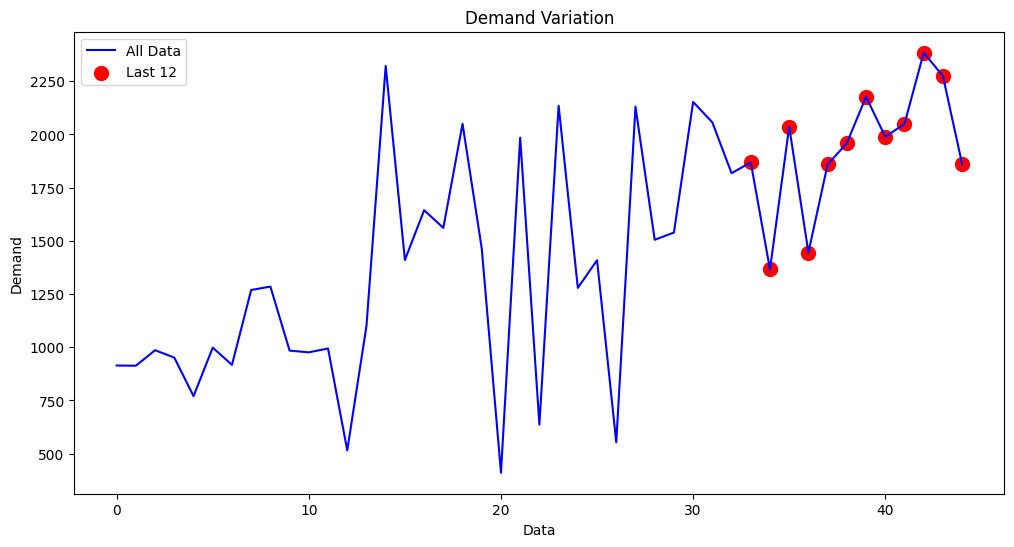

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_svr.index, df_svr['Demand'], label='All Data', color='blue')
plt.scatter(df_svr.index[-12:], df_svr['Demand'].tail(12), color='red', label='Last 12', s=100)

plt.xlabel('Data')
plt.ylabel('Demand')
plt.title('Demand Variation')
plt.legend()

plt.show()

In [ ]:
df_svr['Percentage Change'] = df_svr['Demand'].pct_change() * 100

tolerance = 20
increasing_trend = ((df_svr['Percentage Change'] >= -tolerance) & (df_svr['Percentage Change'] <= tolerance)).all()

if increasing_trend:
    print("The product has an increasing trend with a tolerance of 20%.")
else:
    print("The product has a decreasing trend with a tolerance of 20%.")

The product has a decreasing trend with a tolerance of 20%.
